In [1]:
import pandas as pd 

## Load data
sst_train_path = './ntk/data/sst/train.csv'
sst_train = pd.read_csv(sst_train_path)
sst_train_text = list(sst_train.text.values)
sst_train_label = list(sst_train.label.values)

sst_dev_path = './ntk/data/sst/dev.csv'
sst_dev = pd.read_csv(sst_dev_path)
sst_dev_text = list(sst_dev.text.values)

sst_test_path = './ntk/data/sst/test.csv'
sst_test = pd.read_csv(sst_test_path)
sst_test_text = list(sst_test.text.values)

vocab = set()
token_label_pair = []   # a list of (token, label) tuples
token_doc_freq = {}     # {word: frequency}

## Build vocabulary
for i, text in enumerate(sst_train_text):
    text = text.split(' ')
    label = sst_train_label[i]
    for w in text:
        vocab.add(w)
        token_doc_freq[w] = token_doc_freq.get(w, 0) + 1
        token_label_pair += [(w, label)]


In [2]:
## Build token frequency dictionary for each class
from collections import Counter
token_label_pair_freq = Counter(token_label_pair)
token_freq_pos = {}
token_freq_neg = {}
pos_tokens_freq = {}
neg_tokens_freq = {}
neutral_tokens_freq = {}

for w in vocab:
    freq_pos = token_label_pair_freq[(w, 1)]
    freq_neg = token_label_pair_freq[(w, 0)]
    token_freq_pos[w] = freq_pos
    token_freq_neg[w] = freq_neg

    if freq_pos-freq_neg != 0:
        #We use 10
        rate = (freq_pos-freq_neg)/(freq_pos+freq_neg)*1.0
        if rate>0.5 and freq_pos>5:#positive tokens
            pos_tokens_freq[w] = freq_pos
        if rate<-0.5 and freq_neg>5:
            neg_tokens_freq[w] = freq_neg

    if abs(freq_pos-freq_neg)/(freq_pos+freq_neg)<0.1 and abs(freq_pos-freq_neg)<5:
        neutral_tokens_freq[w] = freq_neg + freq_pos

In [3]:
len(pos_tokens_freq)

411

In [4]:
## Sort the tokens based on their frequency in their corresponding label
from collections import OrderedDict
pos_tokens_freq_sorted = OrderedDict(sorted(pos_tokens_freq.items(), key=lambda item: item[1], reverse=True))
neg_tokens_freq_sorted = OrderedDict(sorted(neg_tokens_freq.items(), key=lambda item: item[1], reverse=True))
neutral_tokens_freq_sorted = OrderedDict(sorted(neutral_tokens_freq.items(), key=lambda item: item[1], reverse=True))

pos_tokens = list(pos_tokens_freq_sorted.keys())
neg_tokens = list(neg_tokens_freq_sorted.keys())
neutral_tokens = list(neutral_tokens_freq_sorted.keys())

In [5]:
import torch

def global_significance(model):
    from matplotlib import pyplot as plt
    pos_tokens_global_score = []
    neg_tokens_global_score = []
    neutral_tokens_global_score = []

    for w in pos_tokens:
        token = [[w]]
        outputs, output_vectors = model(token, torch.LongTensor([1]))
        pos_tokens_global_score.append(output_vectors[0][0])

    for w in neg_tokens:
        token = [[w]]
        outputs, output_vectors = model(token, torch.LongTensor([1]))
        neg_tokens_global_score.append(output_vectors[0][0])

    for w in neutral_tokens:
        token = [[w]]
        outputs, output_vectors = model(token, torch.LongTensor([1]))
        neutral_tokens_global_score.append(output_vectors[0][0])

    plt.style.use('ggplot')  

    plt.plot(range(len(pos_tokens_global_score)), pos_tokens_global_score, '*', label='pos_token')
    plt.plot(range(len(neg_tokens_global_score)), neg_tokens_global_score, '+', label='neg_token')
    plt.plot(range(len(neutral_tokens_global_score)), neutral_tokens_global_score, '.', label='neutral_token')
    
    plt.grid('--')
    plt.xlabel('Token Index')
    plt.ylabel('Global Significance')
    plt.legend()
    return plt

import matplotlib.pyplot as plt
import pickle

def polarity_score_plot(polarity_scores):
    '''
    sst: num_pos=411, num_neg=265
    imdb: num_pos = 414, num_neg=363
    '''
    num_epochs = 500
    num_pos = 411
    num_neg = 265
    for j in range(num_pos-1):
        plt.plot(range(num_epochs), [polarity_scores[i][0][j].cpu().detach().numpy() for i in range(num_epochs)], linestyle='solid', color='blue')
    for j in range(num_neg-1):
        plt.plot(range(num_epochs), [polarity_scores[i][1][j].cpu().detach().numpy() for i in range(num_epochs)], linestyle='dashed', color='red')

    plt.plot(range(num_epochs), [polarity_scores[i][0][num_pos-1].cpu().detach().numpy() for i in range(num_epochs)], linestyle='solid', color='blue', label='pos token')
    plt.plot(range(num_epochs), [polarity_scores[i][1][num_neg-1].cpu().detach().numpy() for i in range(num_epochs)], linestyle='dashed', color='red', label='neg token')

    plt.xlabel('Training Epoch')
    plt.ylabel('Polarity Scores')
    plt.grid(linestyle='--')
    plt.legend()
    return plt
    

/home/jiaxi_li/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


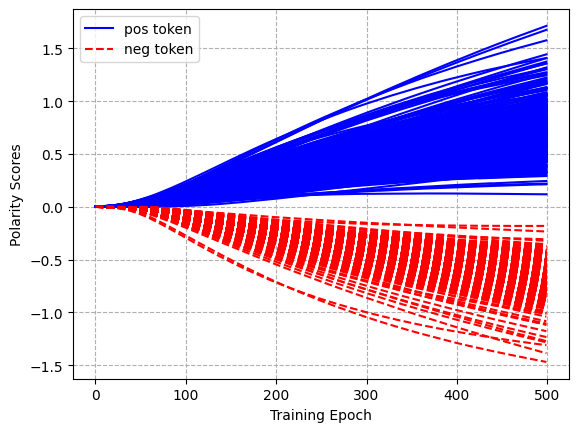

In [6]:
with open("./polarity_scores/mlpsst64relu0.1", "rb") as fp:
    polarity_scores = pickle.load(fp)
plot = polarity_score_plot(polarity_scores)